
# ** Problem Statement  **

Sales predictions summary for the upcoming month by product wise.

• Importance of this question is,
Retailers can analyze the historical sales data, sales trends and consumer behavior to accurately
Forecast the demand. This minimizes overstock or understock situations while ensuring customers find what they want and to acheive the better supply chain management.

In [2]:
import pandas as pd
import numpy as np
!pip install scikit-learn==1.5.2
# data viz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight") # styling your charts

# pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# modeling
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,root_mean_squared_error
!pip install scikeras
from scikeras.wrappers import KerasRegressor
import lightgbm as lgb
import warnings
import time
warnings.filterwarnings('ignore')

print("All modules loaded")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
TensorFlow version: 2.19.0
All modules loaded


In [4]:
url = 'data/sales_train.zip'
df = pd.read_csv(url, sep = ',', parse_dates=["date"], dayfirst=True)

In [5]:
test_url = 'data/test.csv'
test_df = pd.read_csv(test_url, sep = ',')

In [6]:
category_url = 'data/item_categories.csv'
category_df = pd.read_csv(category_url, sep = ',')


In [7]:
item_url = 'data/items.csv'
item_df = pd.read_csv(item_url, sep = ',')

In [8]:
shops_url = 'data/shops.csv'
shops_df = pd.read_csv(shops_url, sep = ',')

In [9]:
item_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [10]:
df.shape

(2935849, 6)

In [11]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [12]:
test_df.shape

(214200, 3)

In [14]:
df.isnull().sum()

,0
date,0
date_block_num,0
shop_id,0
item_id,0
item_price,0
item_cnt_day,0


In [15]:
test_df.isnull().sum()

,0
ID,0
shop_id,0
item_id,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [17]:
print('***************sales_train*********************')
print(df.nunique())
print('*****************test*******************')
print(test_df.nunique())

***************sales_train*********************
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64
*****************test*******************
ID         214200
shop_id        42
item_id      5100
dtype: int64


Observations from the Data sales_train.csv (Sales Data) date:

*   1034 unique dates — suggests daily data over a period of 34 months (date_block_num).

*  shop_id: 60 unique shops.
*  item_id: 21,807 unique items.
*  item_price: 19,993 unique prices — some items may have fluctuating prices.
*   item_cnt_day: 198 unique sales counts for a day — includes both positive and negative values, possibly returns or corrections.


test.csv (Test Data) :

*   ID: 214,200 unique entries — this is the number of test samples for which we need to predict.
*   shop_id: 42 unique shops in the test set — fewer than the training set, so we may need to handle shops that appear in training but not in testing and vice versa.
*   item_id: 5,100 unique items in the test set — fewer items than in the training set.








# **Data cleaning and Removing outliers**

In [18]:
df.query('item_cnt_day<=0').shape

(7356, 6)

In [19]:
df.query('item_cnt_day<=0').head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-01-05,0,25,2552,899.0,-1.0
148,2013-01-23,0,25,2321,999.0,-1.0
175,2013-01-07,0,25,2199,1449.0,-1.0
807,2013-01-02,0,25,2330,599.0,-1.0
1041,2013-01-13,0,25,5034,1989.0,-1.0


In [20]:
df.query('item_price<=0').head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [21]:
df = df[df['item_price'] > 0]

In [22]:
df['item_cnt_day'] = df['item_cnt_day'].apply(lambda x: 1 if x <= 0 else x)

In [23]:
df.query('item_cnt_day<=0').shape

(0, 6)

In [24]:
df.query('item_id<=0').head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1972636,2014-09-01,20,54,0,58.0,1.0


In [25]:
df = df[df['item_id'] > 0]

In [26]:
df.query('date_block_num<0').shape

(0, 6)

In [27]:
print(df.duplicated().sum())

6


In [28]:
df = df.drop_duplicates()

In [29]:
print(df.duplicated().sum())

0


In [30]:
print("✅ Data loaded. Ready for EDA.")

✅ Data loaded. Ready for EDA.


# ***Aggregate monthly sales for the 34 months (item_cnt_day)***

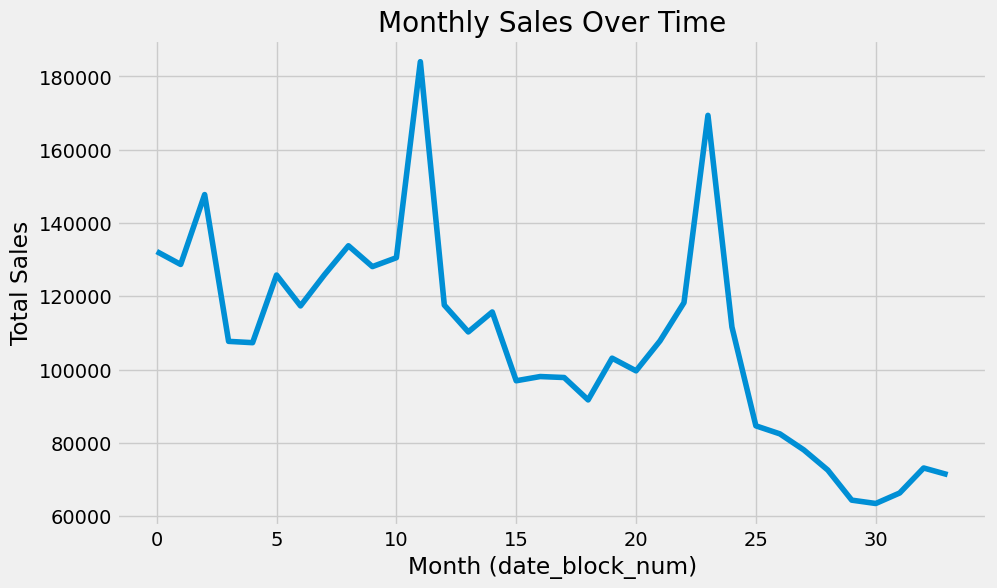

In [31]:

plt.figure(figsize=(10,6))
plt.plot(df.groupby('date_block_num')['item_cnt_day'].sum())
plt.title('Monthly Sales Over Time')
plt.xlabel('Month (date_block_num)')
plt.ylabel('Total Sales')
plt.show()

## **Top 10 items by total sales**

In [32]:
top_items = df.groupby('item_id')['item_cnt_day'].sum().sort_values(ascending=False).head(10)


In [33]:
merged_df = pd.merge(top_items, item_df, on='item_id', how='inner')
merged_df.head(10)

,item_id,item_cnt_day,item_name,item_category_id
0,20949,187663.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
1,2808,17264.0,"Diablo III [PC, Jewel, русская версия]",30
2,3732,16700.0,"Grand Theft Auto V [PS3, русские субтитры]",19
3,17717,15830.0,Прием денежных средств для 1С-Онлайн,79
4,5822,14526.0,Playstation Store пополнение бумажника: Карта ...,35
5,3734,11774.0,"Grand Theft Auto V [Xbox 360, русские субтитры]",23
6,6675,10339.0,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,12
7,3731,10111.0,"Grand Theft Auto V [PC, русские субтитры]",30
8,1855,10050.0,"Battlefield 4 [PC, русская версия]",30
9,16787,9282.0,"Одни из нас [PS3, русская версия]",19


## **Top 10 shops by total sales**

In [34]:
top_shops = df.groupby('shop_id')['item_cnt_day'].sum().sort_values(ascending=False).head(10)


In [35]:
top_shops_df = pd.merge(top_shops, shops_df, on='shop_id', how='inner')
top_shops_df.head(10)

,shop_id,item_cnt_day,shop_name
0,31,311681.0,"Москва ТЦ ""Семеновский"""
1,25,242552.0,"Москва ТРК ""Атриум"""
2,54,186503.0,"Химки ТЦ ""Мега"""
3,28,184993.0,"Москва ТЦ ""МЕГА Теплый Стан"" II"
4,42,145445.0,"СПб ТК ""Невский Центр"""
5,57,141738.0,"Якутск Орджоникидзе, 56"
6,27,136972.0,"Москва ТЦ ""МЕГА Белая Дача II"""
7,6,101018.0,"Воронеж (Плехановская, 13)"
8,58,82081.0,"Якутск ТЦ ""Центральный"""
9,46,79194.0,"Сергиев Посад ТЦ ""7Я"""


## **Plot item price distribution**

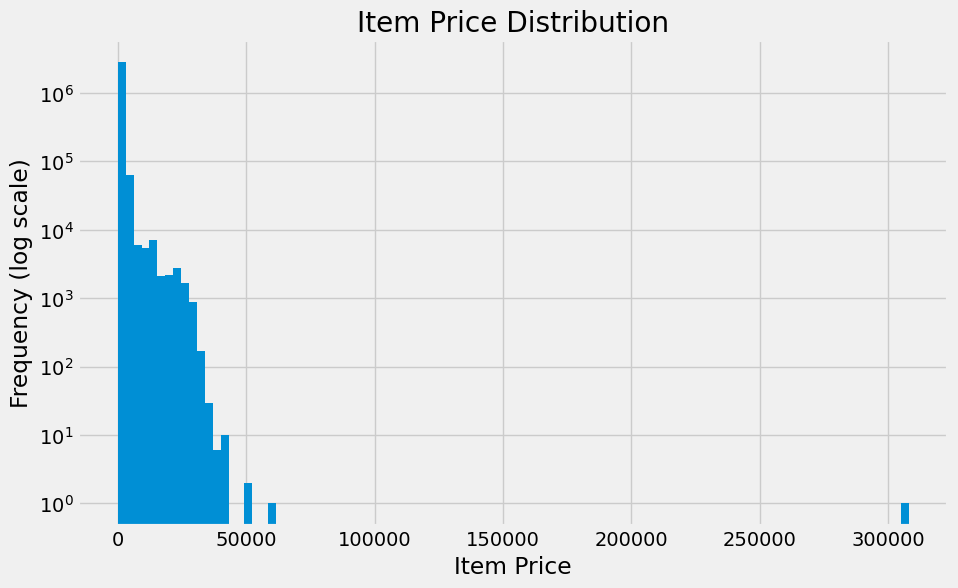

In [36]:

plt.figure(figsize=(10,6))
plt.hist(df['item_price'], bins=100, log=True)
plt.title('Item Price Distribution')
plt.xlabel('Item Price')
plt.ylabel('Frequency (log scale)')
plt.show()

# **Finding the density of the sales price and removing the outliers**

Text(0.5, 1.0, 'Density of the Item Price')

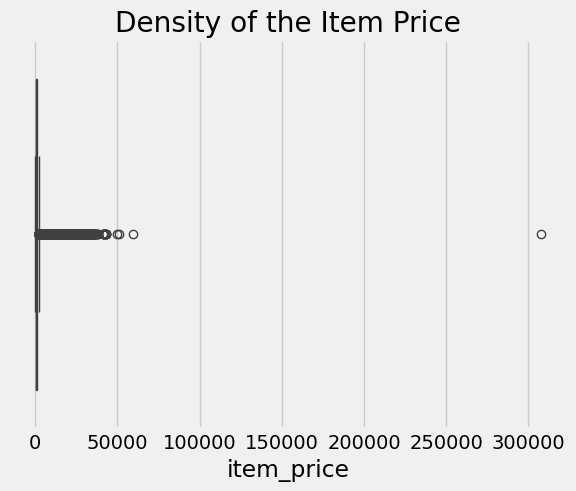

In [37]:
sns.boxplot(x=df['item_price'], orient='h').set_title("Density of the Item Price")

In [38]:
df.shape

(2935841, 6)

In [39]:
highest_sales = pd.merge(df[df['item_price']>40000], item_df, on='item_id', how='inner')
highest_sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-09-17,8,12,11365,59200.0,1.0,Доставка (EMS),9
1,2013-10-24,9,12,7238,42000.0,1.0,UserGate Proxy & Firewall 6.X до 100 сессий,75
2,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75
3,2014-03-20,14,25,13199,50999.0,1.0,Коллекционные шахматы (Властелин Колец),69
4,2014-11-20,22,12,14173,40900.0,1.0,Лицензия 1С-Битрикс: Управление сайтом - Эксперт,75
5,2015-01-29,24,12,7241,49782.0,1.0,UserGate Proxy & Firewall 6.X с модулем фильтр...,75
6,2015-10-23,33,42,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
7,2015-10-20,33,38,13403,41990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
8,2015-10-20,33,12,13403,41990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
9,2015-10-29,33,12,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16


In [40]:
df=df[df['item_price']<40000]

In [41]:
df.shape

(2935827, 6)

Text(0.5, 1.0, 'Density of the Item Price less than 40000')

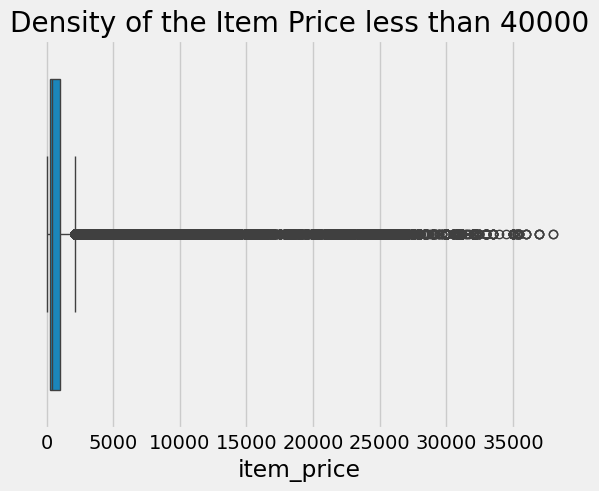

In [42]:
sns.boxplot(x=df['item_price'], orient='h').set_title("Density of the Item Price less than 40000")

Text(0.5, 1.0, 'Density of the Item Price')

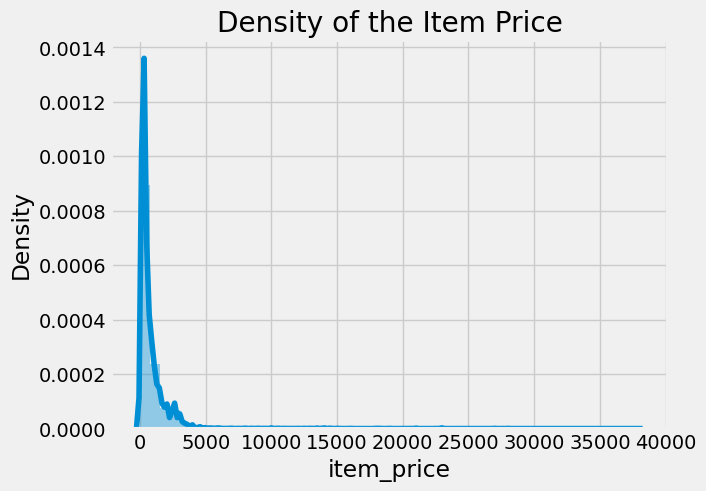

In [43]:
sns.distplot(df['item_price']).set_title("Density of the Item Price")

In [44]:
df=df[df['item_price']<5000]

Text(0.5, 1.0, 'Density of the Item Price less than 5000')

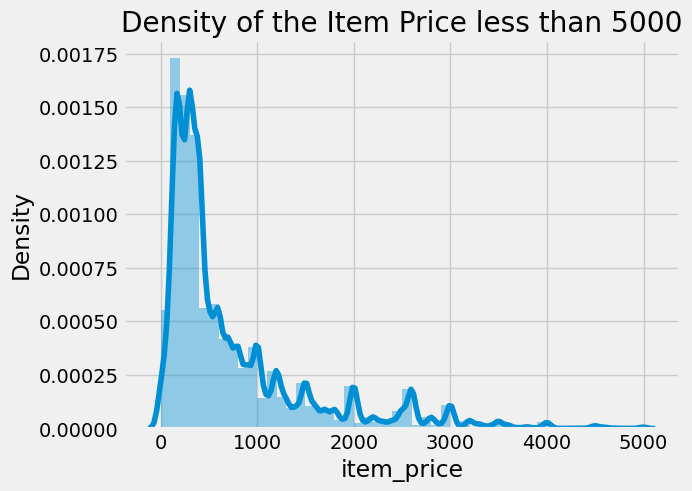

In [45]:
sns.distplot(df['item_price']).set_title("Density of the Item Price less than 5000")

Text(0.5, 1.0, 'Density of the Item Price less than 5000')

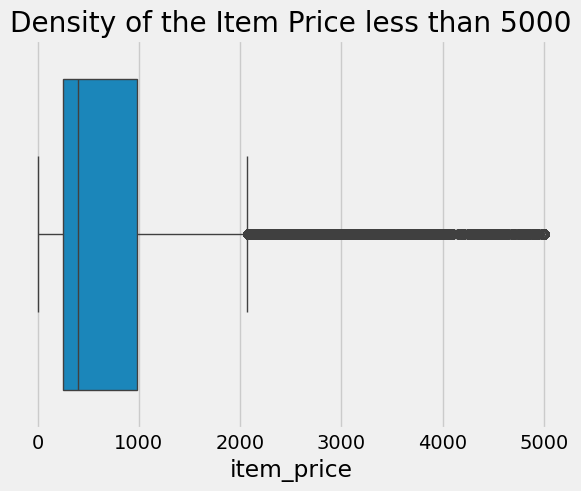

In [46]:
sns.boxplot(x=df['item_price'], orient='h').set_title("Density of the Item Price less than 5000")

# **Item Sales Distribution**

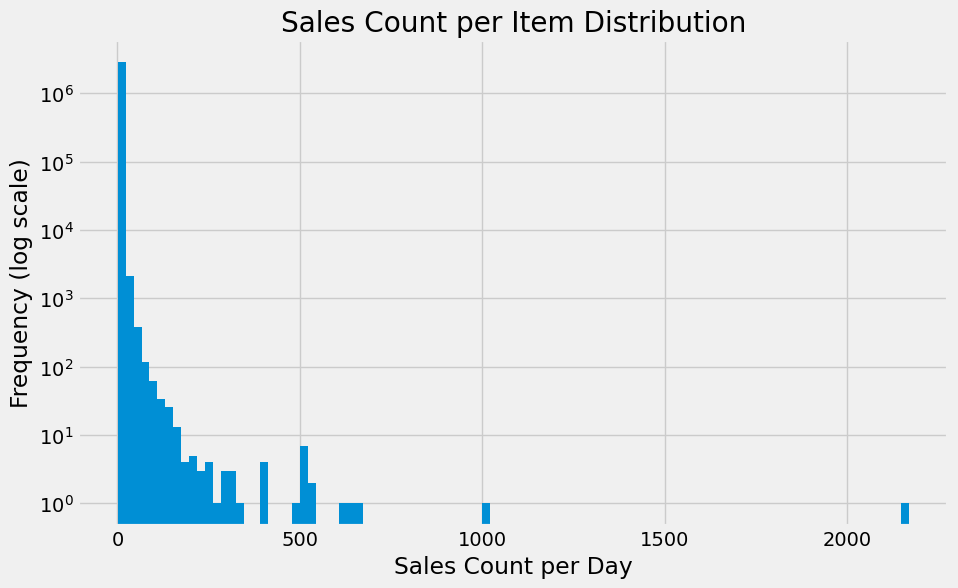

In [47]:
plt.figure(figsize=(10,6))
plt.hist(df['item_cnt_day'], bins=100, log=True)
plt.title('Sales Count per Item Distribution')
plt.xlabel('Sales Count per Day')
plt.ylabel('Frequency (log scale)')
plt.show()

Text(0.5, 1.0, 'Density of the Item Count')

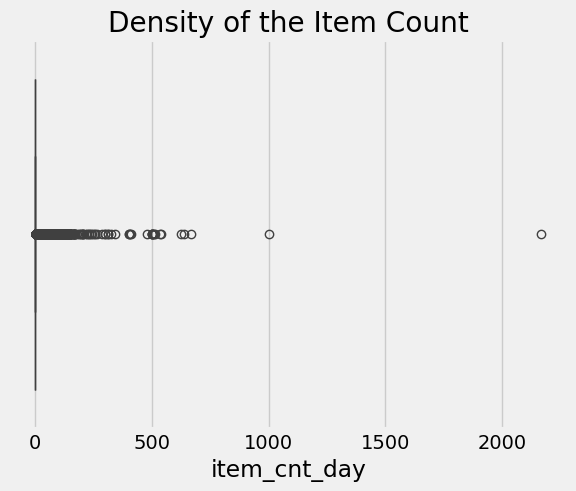

In [48]:
sns.boxplot(x=df['item_cnt_day'], orient='h').set_title("Density of the Item Count")

In [49]:
df[df['item_cnt_day']>10].shape

(9937, 6)

In [50]:
df[df['item_cnt_day']<10].shape

(2890291, 6)

In [51]:
df=df[df['item_cnt_day']<10]

Text(0.5, 1.0, 'Density of the Item Count less than 10')

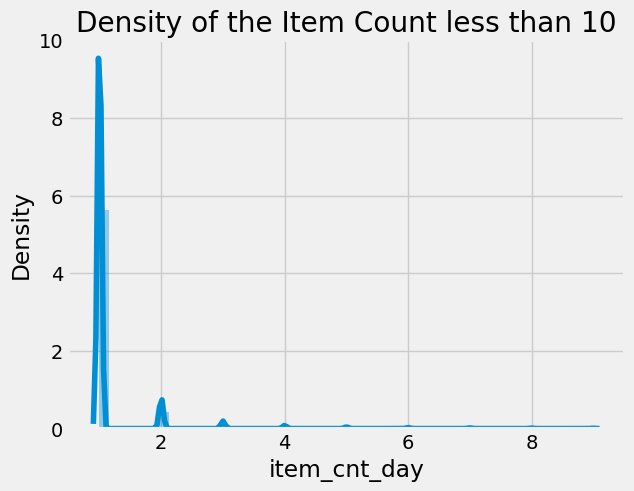

In [52]:
sns.distplot(df['item_cnt_day']).set_title("Density of the Item Count less than 10")

In [53]:
df.shape

(2890291, 6)

# **Aggregate Sales per Month**

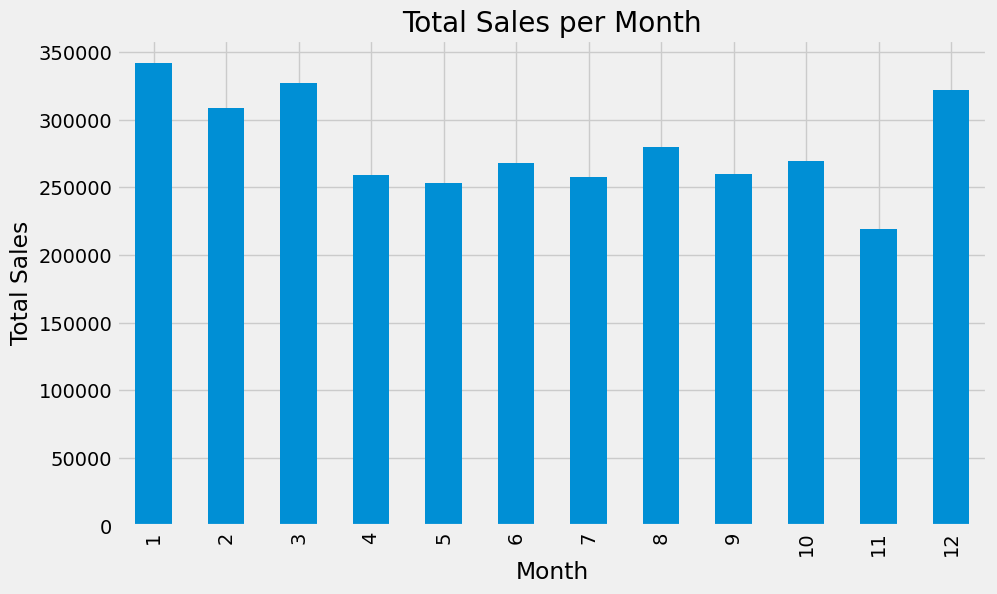

In [54]:
# Add 'month' column
df['month'] = df['date'].dt.month

# Aggregate sales by month
monthly_sales_by_month = df.groupby('month')['item_cnt_day'].sum()


# Plot
plt.figure(figsize=(10,6))
monthly_sales_by_month.plot(kind='bar')
plt.title('Total Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

In [55]:
df['month_year'] = df['date'].dt.month.astype(str)  + ' ' + df['date'].dt.year.astype(str)
df['year'] = df['date'].dt.year.astype(str)
# Aggregate sales by month
#monthly_sales_by_month_year = df.groupby('month_year')['item_cnt_day'].sum().reset_index()

top_sale_items_df = pd.merge(df, top_items, on='item_id', how='inner')
summary = top_sale_items_df.groupby(['month_year', 'item_id'])['item_cnt_day_x'].sum().reset_index()

In [56]:
summary = summary.rename(columns={'item_cnt_day_x': 'Agg_sales'})

In [57]:
summary.head()

,month_year,item_id,Agg_sales
0,1 2013,2808,780.0
1,1 2013,5822,300.0
2,1 2013,17717,135.0
3,1 2014,1855,1053.0
4,1 2014,2808,333.0


In [58]:
import plotly.express as px


fig = px.scatter(summary, x='item_id', y='Agg_sales', color='Agg_sales', size='Agg_sales',
                facet_col='month_year', facet_col_wrap=4, height=2000,
    width=1200, title="Monthly sales summary for top 10 highest sale items" )
fig.show()


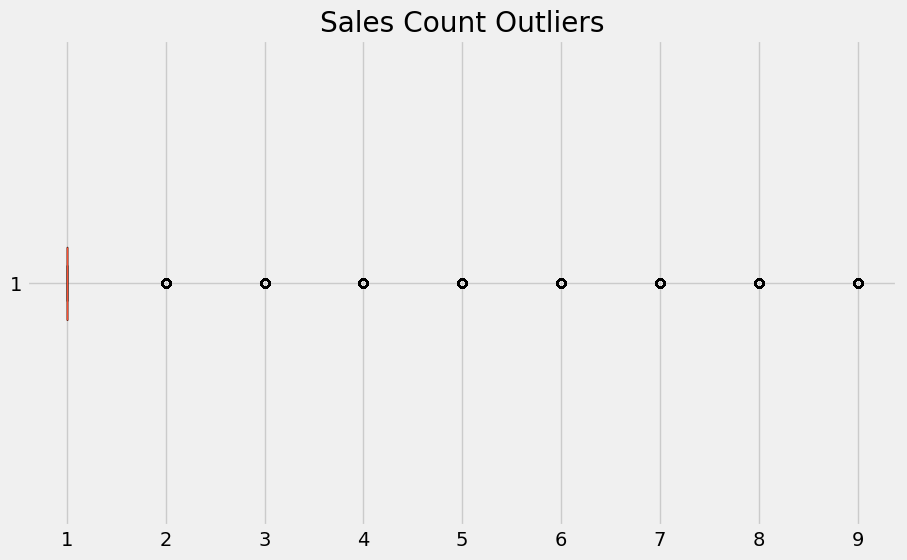

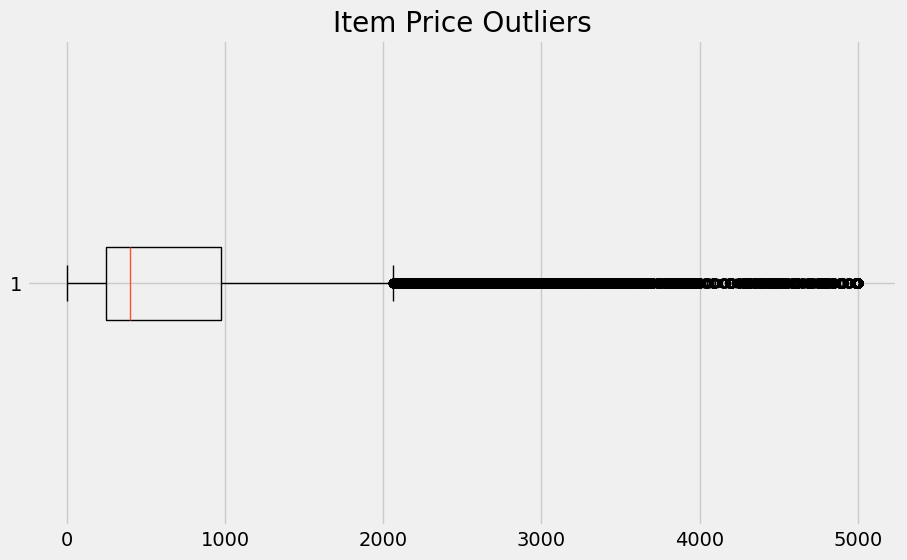

In [59]:
# Check for sales count outliers
plt.figure(figsize=(10,6))
plt.boxplot(df['item_cnt_day'], vert=False)
plt.title('Sales Count Outliers')
plt.show()

# Check for price outliers
plt.figure(figsize=(10,6))
plt.boxplot(df['item_price'], vert=False)
plt.title('Item Price Outliers')
plt.show()

In [60]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,month_year,year
0,2013-01-02,0,59,22154,999.00,1.0,1,1 2013,2013
1,2013-01-03,0,25,2552,899.00,1.0,1,1 2013,2013
2,2013-01-05,0,25,2552,899.00,1.0,1,1 2013,2013
3,2013-01-06,0,25,2554,1709.05,1.0,1,1 2013,2013
4,2013-01-15,0,25,2555,1099.00,1.0,1,1 2013,2013


# **Aggregating sales per month**

In [61]:
# Aggregate sales to monthly level
df['revenue'] = df['item_price'] * df['item_cnt_day']

In [62]:
monthly_sales = df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day': 'sum',
    'revenue': 'sum'
}).reset_index()

In [63]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,month_year,year,revenue
0,2013-01-02,0,59,22154,999.00,1.0,1,1 2013,2013,999.00
1,2013-01-03,0,25,2552,899.00,1.0,1,1 2013,2013,899.00
2,2013-01-05,0,25,2552,899.00,1.0,1,1 2013,2013,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1,1 2013,2013,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1,1 2013,2013,1099.00


In [64]:
monthly_sales.shape

(1591312, 5)

In [65]:
monthly_sales.head()

,date_block_num,shop_id,item_id,item_cnt_day,revenue
0,0,0,32,6.0,1326.0
1,0,0,33,3.0,1041.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,257.0


In [66]:
# Rename columns for clarity
monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

In [67]:
monthly_sales.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue
0,0,0,32,6.0,1326.0
1,0,0,33,3.0,1041.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,257.0


# **Making sure all the Shop_id and Item_id data is available for every month**


In [68]:
import itertools

# Create a grid to ensure every month has a row for every combination of shop_id and item_id
grid = []
for block_num in range(34):
    cur_shops = df[df['date_block_num'] == block_num]['shop_id'].unique()
    cur_items = df[df['date_block_num'] == block_num]['item_id'].unique()

    # Use itertools.product to create the Cartesian product of shops, items, and the current date_block_num
    grid.append(np.array(list(itertools.product(cur_shops, cur_items, [block_num]))))

# Combine all monthly grids into one DataFrame
grid = pd.DataFrame(np.vstack(grid), columns=['shop_id', 'item_id', 'date_block_num'])

In [69]:
# Merge the grid with monthly sales data
monthly_sales = pd.merge(grid, monthly_sales, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

In [70]:
monthly_sales.head()

,shop_id,item_id,date_block_num,item_cnt_month,revenue
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


In [96]:
X_train = monthly_sales[monthly_sales['date_block_num'] < 33]
y_train = X_train['item_cnt_month']
y_train.head()

,item_cnt_month
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


**Spliting Training and Testing dataset by first 25 week for train the model and remaining for testing the model**


In [97]:
# Split the data in to training set and validation set
X_train = monthly_sales[monthly_sales['date_block_num'] < 25]
X_test = monthly_sales[monthly_sales['date_block_num']  > 25]


# Target variable (sales for the month)
y_train = X_train['item_cnt_month']
y_test = X_test['item_cnt_month']

# Drop the target variable from feature sets
X_train = X_train.drop(['item_cnt_month'], axis=1)
X_test = X_test.drop(['item_cnt_month'], axis=1)



## **Baselining the model using Dummy Regressor**

In [73]:
from sklearn.dummy import DummyRegressor


In [330]:
from sklearn.metrics import mean_squared_error
dummy = DummyRegressor()
dummy.fit(X_train, y_train)

# Predictions on test
# Predictions on test
dummy_predict = dummy.predict(X_test)

rmse = root_mean_squared_error(y_test, dummy_predict) # For RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



Root Mean Squared Error (RMSE): 1.44


Root mean square error for the test data if 1.44 in this DummyRegressor.

Need to work on the actual model for getting the better score.

## **Linear Regression model for Baselining**

In [99]:
# Use default parameters or minimal tuning

linear_reg_baseline = LinearRegression()
linear_reg_baseline.fit(X_train, y_train)
y_pred_linear_reg_baseline = linear_reg_baseline.predict(X_test)

In [100]:
rmse = root_mean_squared_error(y_test, y_pred_linear_reg_baseline) # For RMSE

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 1.13


In [101]:
train_score_lin_reg = linear_reg_baseline.score(X_train, y_train)
test_score_lin_reg = linear_reg_baseline.score(X_test, y_test)
print(f"Train Score: {train_score_lin_reg:.2f}")
print(f"Test Score: {test_score_lin_reg:.2f}")

Train Score: 0.41
Test Score: 0.38


# **Observation :**   RMSE is getting better with Linear Regression model compare with dummy regressor

# **XGBoost Regressor:**

In [334]:
# Define XGBRegressor model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Instantiate XGBRegressor with the parameters
xgb_model = xgb.XGBRegressor(**params)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_y_pred = xgb_model.predict(X_test)

rmse = root_mean_squared_error(y_test, xgb_y_pred) # For RMSE

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 0.81


# **XGBRegressor with GridSearch**

In [89]:
# Perform grid search
# Initialize XGBRegressor
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 8, 10],
    'learning_rate': [0.05, 0.1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the model and time it
start_time = time.time()
grid_search.fit(X_train, y_train)
fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
# Fit the grid search


# Print best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Get the best estimator
best_xgb_model = grid_search.best_estimator_
# Convert the best negative MSE score back to RMSE for interpretation
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE: {best_rmse:.2f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best score: -1.1380417402198642
Best RMSE: 1.07


In [91]:
train_score_xgb = best_xgb_model.score(X_train, y_train)
test_score_xgb = best_xgb_model.score(X_test, y_test)
print(f"Train Score: {train_score_xgb:.2f}")
print(f"Test Score: {train_score_xgb:.2f}")

Train Score: 0.73
Test Score: 0.73


# **RandomForest Regressor**

In [74]:
# Create a RandomForestRegressor instance
# n_estimators: number of trees in the forest
# random_state: for reproducibility
randomforest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
randomforest_model.fit(X_train, y_train)

# Make predictions
randomforest_y_pred = randomforest_model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, randomforest_y_pred) # For RMSE

# Access feature importances
print(f"Feature Importances: {randomforest_model.feature_importances_}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



Feature Importances: [0.01600857 0.34205894 0.02516313 0.61676936]
Root Mean Squared Error (RMSE): 0.73


# **Random Forest Regressor with Grid Search**

In [75]:
rf_regressor = RandomForestRegressor(random_state=42)
param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5,8],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    }
grid_search = GridSearchCV(estimator=rf_regressor,
                               param_grid=param_grid,
                               cv=2, # Number of cross-validation folds
                               scoring='neg_mean_squared_error', # Or other regression metrics like 'r2'
                               n_jobs=-1, # Use all available cores for parallel processing
                               verbose=1) # Display progress messages

start_time = time.time()
grid_search.fit(X_train, y_train) # X_train and y_train are your training features and target
fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])


best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"time taken:{fit_time}")
print(f"Best RMSE: {best_rmse:.2f}")


Fitting 2 folds for each of 16 candidates, totalling 32 fits
time taken:375.73037073016167
Best RMSE: 0.93


In [102]:
train_score_rf = best_estimator.score(X_train, y_train)
test_score_rf = best_estimator.score(X_test, y_test)
print(f"Train Score: {train_score_rf:.2f}")
print(f"Test Score: {test_score_rf:.2f}")

Train Score: 0.82
Test Score: 0.72


# **Timeseries Analysis using LGBM**

Creating the lag columns for timeseries analysis

In [78]:

ts_df = monthly_sales.copy()
ts_df['lag1'] = ts_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_month'].shift(1)
ts_df['lag2'] = ts_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_month'].shift(2)

ts_df = ts_df.fillna(0)
ts_df.head()


,shop_id,item_id,date_block_num,item_cnt_month,revenue,lag1,lag2
0,59,22154,0,1.0,999.0,0.0,0.0
1,59,2552,0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,0.0,0.0


In [104]:
# Split the data in to training set and validation set
X_train = ts_df[ts_df['date_block_num'] < 25]
X_test = ts_df[ts_df['date_block_num']  > 25]

# Target variable (sales for the month)
y_train = X_train['item_cnt_month']
y_test = X_test['item_cnt_month']

# Drop the target variable from feature sets
X_train = X_train.drop(['item_cnt_month'], axis=1)
X_test = X_test.drop(['item_cnt_month'], axis=1)

In [105]:
X_test.shape

(1864948, 6)

In [106]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 8648999, number of used features: 4
[LightGBM] [Info] Start training from score 0.320878


LGBMRegressor()

In [107]:
predictions = model.predict(X_test)

In [108]:
# Evaluate the model
rmse = root_mean_squared_error(y_test, predictions) # For RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 0.78


In [109]:
train_score_lgbm = model.score(X_train, y_train)
test_score_lgbm = model.score(X_test, y_test)
print(f"Train Score: {train_score_lgbm:.2f}")
print(f"Test Score: {test_score_lgbm:.2f}")

Train Score: 0.81
Test Score: 0.70


# **Validating the testing data for shop_id 59 and itemid 22162**

In [112]:
# Filtering the data from testing set
X_test_filtered = ts_df[(ts_df['shop_id'] ==59) & (ts_df['item_id'] ==22162) & (ts_df['date_block_num'] > 25)]

# Target variable (sales for the month)
y_test_filtered = X_test_filtered['item_cnt_month']

# Drop the target variable from feature sets
X_test_filtered = X_test_filtered.drop(['item_cnt_month'], axis=1)

X_test_filtered.head()

,shop_id,item_id,date_block_num,revenue,lag1,lag2
9050371,59,22162,26,1596.0,0.0,0.0
9374557,59,22162,27,349.0,0.0,0.0
9633849,59,22162,28,349.0,0.0,0.0
9835621,59,22162,29,0.0,0.0,0.0
9935387,59,22162,30,0.0,0.0,0.0


In [114]:
predictions_filtered = model.predict(X_test_filtered)

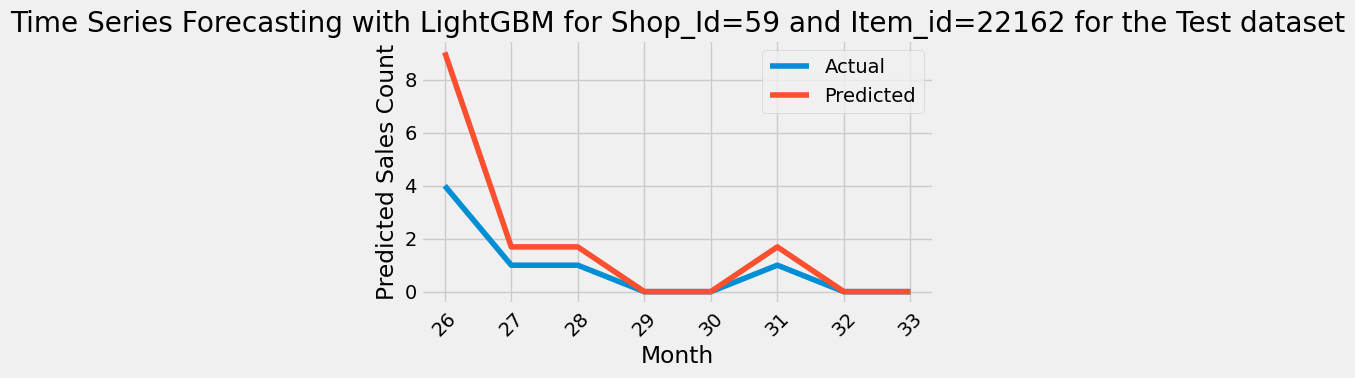

In [118]:
plt.figure(figsize=(6, 4))
plt.plot(X_test_filtered['date_block_num'], y_test_filtered, label='Actual')
plt.plot(X_test_filtered['date_block_num'], predictions_filtered, label='Predicted')
plt.xticks(X_test_filtered['date_block_num'], rotation=45)

plt.xlabel("Month")
plt.ylabel("Predicted Sales Count")
plt.title("Time Series Forecasting with LightGBM for Shop_Id=59 and Item_id=22162 for the Test dataset")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [119]:
data_list = [
    {'Name': 'Linear Regression', 'training_score': train_score_lin_reg, 'testing_score': test_score_lin_reg},
    {'Name': 'XGBRegressor', 'training_score': train_score_xgb, 'testing_score': test_score_xgb},
    {'Name': 'Random Forest', 'training_score': train_score_rf, 'testing_score': test_score_rf},
    {'Name': 'LGBM', 'training_score': train_score_lgbm, 'testing_score': test_score_lgbm},
]

df_from_list_of_dicts = pd.DataFrame(data_list)
df_from_list_of_dicts['training_score'] = df_from_list_of_dicts['training_score'].round(2)
df_from_list_of_dicts['testing_score'] = df_from_list_of_dicts['testing_score'].round(2)
print(df_from_list_of_dicts)

                Name  training_score  testing_score
0  Linear Regression            0.41           0.38
1       XGBRegressor            0.73           0.67
2      Random Forest            0.82           0.72
3               LGBM            0.81           0.70
